In [6]:
%%capture
%pip install neqsim

#To check for methods in a Java object 
#from neqsim import methods

# Experimental data
Experimental data is collected.

In [7]:
import pandas as pd
expdata_df = pd.read_csv('../../../data/thermodynamics/heatcapacity/oxygen.csv')
expdata_df

,Temperature (K),Specific Heat Capacity (J/(mol*K))
0,100,29.10
1,200,29.11
2,300,29.39
3,400,30.10
4,500,31.08
5,600,32.11
6,700,32.98
7,800,33.74
8,900,34.36
9,1000,34.86


<Figure size 640x480 with 0 Axes>

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


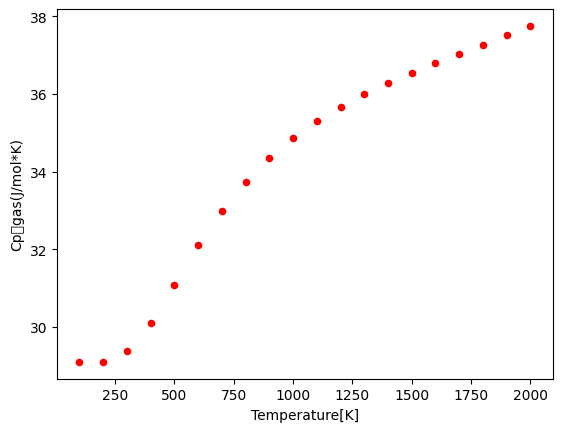

In [8]:
from matplotlib import pyplot as plt
fig = plt.figure()

expdata_df.plot(x='Temperature (K)', y='Specific Heat Capacity (J/(mol*K))', kind='scatter',ylabel='Cp	gas(J/mol*K)', xlabel='Temperature[K]',color='red')

plt.show()

# Evaluation of experimental data

In this section the experimental data will be evaluated and eventual some data sets will be removed from the set.

# Compare to NeqSim Calculations

## NeqSim calculations at 288.15 K

<Figure size 640x480 with 0 Axes>

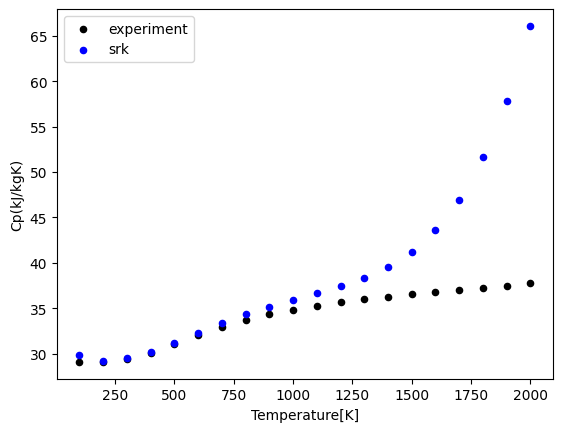

In [9]:
import neqsim
from neqsim.thermo.thermoTools import fluid, TPflash, fluidComposition,bubp
import pandas as pd
import numpy as np

fluid1 = fluid('srk')
fluid1.addComponent('oxygen', 1.0)
fluid1.setTemperature(15.0, 'C')
fluid1.setPressure(1.0, 'bara')

def heatcap(input):
    fluid1.setTemperature(input[0], 'K')
    TPflash(fluid1)
    fluid1.initProperties()
    return fluid1.getPhase('gas').getCp('J/molK')

temperatures = expdata_df['Temperature (K)'].values.tolist()
input = zip(temperatures)
cP_res = [heatcap(inp) for inp in input]

dataWithExperiment = expdata_df.assign(cP_res = cP_res)

from matplotlib import pyplot as plt
fig = plt.figure()	
plot1 = dataWithExperiment.plot(x='Temperature (K)', y='Specific Heat Capacity (J/(mol*K))', kind='scatter',ylabel='Cp(kJ/kgK)', xlabel='Temperature[K]',color='black')	
dataWithExperiment.plot(ax=plot1, x='Temperature (K)', y='cP_res', kind='scatter',ylabel='Cp(kJ/kgK)', xlabel='Temperature[K]',color='blue')	
plt.legend(['experiment', 'srk'])
plt.show()

# Parameter fitting

## Manual fitting

## Automatic fitting